In [2]:
%load_ext autoreload
%autoreload 2

In [16]:
# Standard library imports.
from statistics import mean

# Third party imports.
from dotenv import load_dotenv
from matplotlib import pyplot
from langchain_core.load import loads

# Local imports.
from sunshower.engine import start

In [4]:
# Load my API keys as environment variables.
load_dotenv()

True

In [ ]:
start(file_name="example.yaml")

In [5]:
# Define the prices of each model. 
# - Currently, only have token costs from OpenAI. Need to get other providers.
# - This data was last collected on 2025-11-18.
PRICES = {
    "gpt-4o-2024-08-06": {
        "input": 3.75 / 1_000_000,
        "output": 15.00 / 1_000_000,
    },
    "gpt-4.1-2025-04-14": {
        "input": 3.00 / 1_000_000,
        "output": 12.00 / 1_000_000,
    },
    "gpt-5-2025-08-07": {
        "input": 1.25 / 1_000_000,
        "output": 10.00 / 1_000_000,
    },
}

In [ ]:
# Save the results of each experiment in a Python list.
results = {}
with open(file="results.ndjson", mode="r", encoding="UTF-8") as file:
    for line in file.readlines():
        result = loads(line)
        team_name = result["name"]
        del result["name"]
        try:
            results[team_name].append(result)
        except KeyError:
            results[team_name] = []
            results[team_name].append(result)

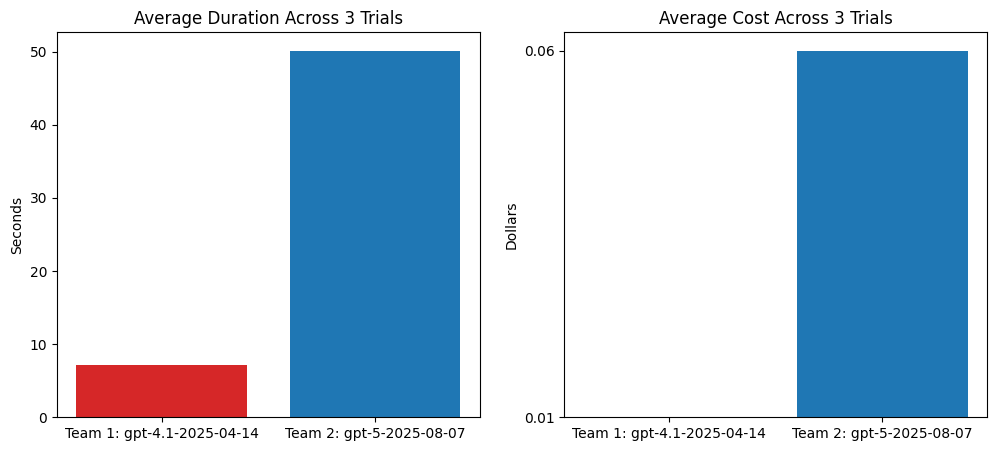

In [51]:
# Init the figure and the charts it will contain.
figure, (ax1, ax2) = pyplot.subplots(1, 2, figsize=(12, 5))

trial_count = len(next(iter(results.values())))

# Get data for the chart.
duration_chart_names = []
duration_chart_averages = []
for team_name, experiments in results.items():
    average = mean(float(experiment["time_taken"]) for experiment in experiments)
    models = [
        message.response_metadata["model_name"]
        for entry in experiments
        for message in entry["messages"]
        if hasattr(message, "response_metadata")
        and "model_name" in message.response_metadata
    ]
    duration_chart_names.append(f"{team_name}: {", ".join(set(models))}")
    duration_chart_averages.append(average)


# Build the chart.
ax1.bar(
    duration_chart_names,
    duration_chart_averages,
    label=duration_chart_names,
    color=["tab:red", "tab:blue", "tab:orange"]
)
ax1.set_ylabel("Seconds")
ax1.set_title(f"Average Duration Across {trial_count} Trials")

# Get data for the chart.
cost_chart_names = []
cost_chart_averages = []
for team_name, experiments in results.items():
    all_experiment_costs = []
    for experiment in experiments:
        experiment_costs = []
        for message in experiment["messages"]:
            if message.type == "ai":
                model_name = message.response_metadata["model_name"]
                prompt_tokens = message.response_metadata["token_usage"]["prompt_tokens"]
                prompt_cost = prompt_tokens * PRICES[model_name]["output"]
                completion_tokens = message.response_metadata["token_usage"]["completion_tokens"]
                completion_cost = completion_tokens * PRICES[model_name]["output"]
                experiment_costs.append(prompt_cost + completion_cost)
        all_experiment_costs.append(sum(experiment_costs))
    cost_chart_averages.append(f"{mean(all_experiment_costs):.2f}")
    models = [
        message.response_metadata["model_name"]
        for entry in experiments
        for message in entry["messages"]
        if hasattr(message, "response_metadata")
        and "model_name" in message.response_metadata
    ]
    cost_chart_names.append(f"{team_name}: {", ".join(set(models))}")

# Build the chart.
ax2.bar(
    cost_chart_names,
    cost_chart_averages,
    label=cost_chart_names,
    color=["tab:red", "tab:blue", "tab:orange"]
)
ax2.set_ylabel("Dollars")
ax2.set_title(f"Average Cost Across {trial_count} Trials")

# TODO: add attribute that shows if reasoning was enabled or not
# TODO: change legend to show task and team attributes (model, tools, reasoning)

# Show the figure.
pyplot.show()